# Series de Tiempo

Breve introducción en *Series de Tiempo* realizado para la Diplomatura en Ciencias de Datos de la FaMAF, Lic. Sebastián Coca.

La notebook es armada con las notas de clase y la página [cienciadedatos.net](https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python) y [skforecast.org](https://skforecast.org/0.13.0/user_guides/forecasting-sarimax-arima.html).

No pretende ser exaustiva en la temático, sólo introducir al tema y dar las herramientas mínimas para trabajar con modelos ARIMA y SARIMAX.

## Introducción y visualiazión

Las series de tiempo **tienen** un orden en su presentación/recolección, y su estructura depende de ese orden. En general se tiene una parte determinista y otra no, y la idea es modelar *todo*. Habitualmente el *ruido* viene por un proceso estocástico.

Es muy importante trabajar las visualizaciones en series de tiempo.


In [ ]:
#@title Carga de librerías

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from datetime import datetime, timedelta
import time

import plotly.graph_objects as go
import math
from collections import defaultdict
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from matplotlib import pyplot as plt



# Let's determine the current directory and store it in a variable
# (execute this cell only once at the beginning)
# ayudas comandos: https://neptune.ai/blog/google-colab-dealing-with-files-2


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

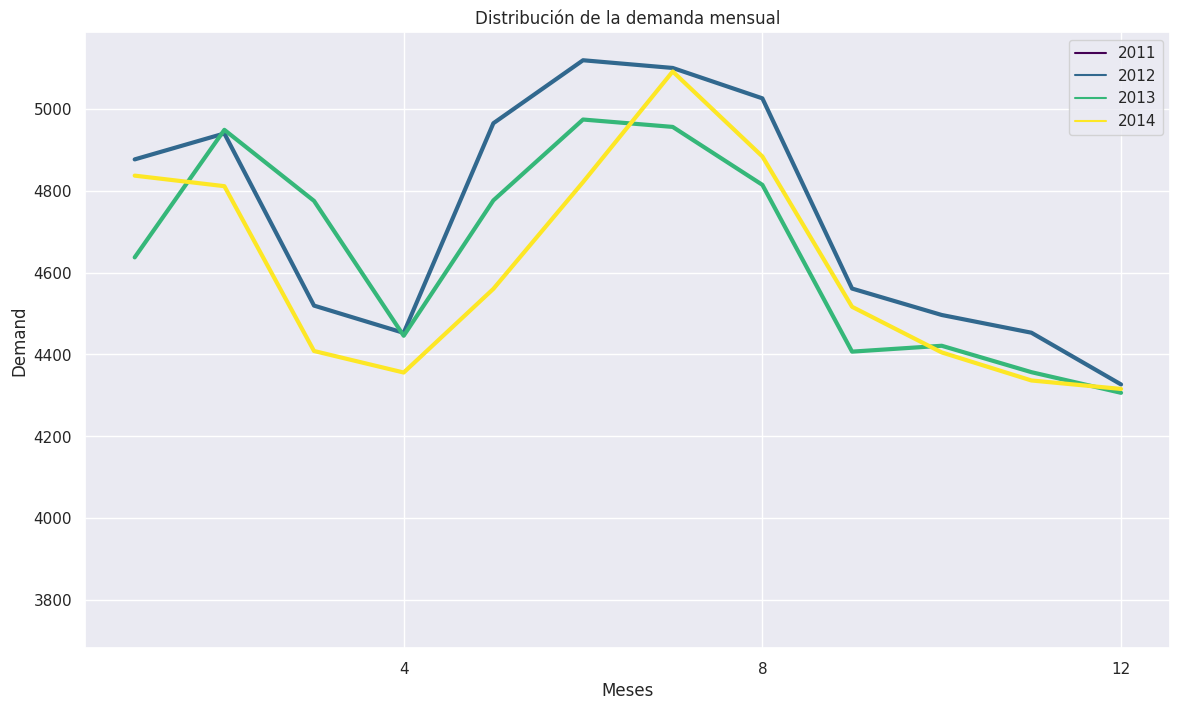

In [ ]:
#@title Demanda mensual

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=df_monthly, x ='m', y = 'Demand',
                  hue='y', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Demand')
plt.xlabel('Meses')
plt.title('Distribución de la demanda mensual')
plt.show()


In [ ]:
#@title Gráfico de radar de la distribución de la demanda mensual
#extract color palette, the palette name can be changed
pal = list(sns.color_palette(palette='viridis', n_colors=len(years)).as_hex())

months = list(reversed([str(i) for i in list(range(1,13))])) + ['12']
list_dem = [[list(df_monthly[df_monthly['y']==i]['Demand'])[int(n)-1] for n in months] for i in years]

fig = go.Figure()
for pm,d,c in zip(list_dem, years, pal):
    fig.add_trace(go.Scatterpolar(r = pm, theta=months, fill= 'toself',
                                  name=str(d), marker = dict(color = c)))
fig.update_layout(polar = dict(radialaxis = dict(visible = True, range=[4200,5200]),
                               angularaxis = dict(rotation=90)),
                  showlegend=True, width=720, height=720,
                  font = dict(size=14))
fig.show()

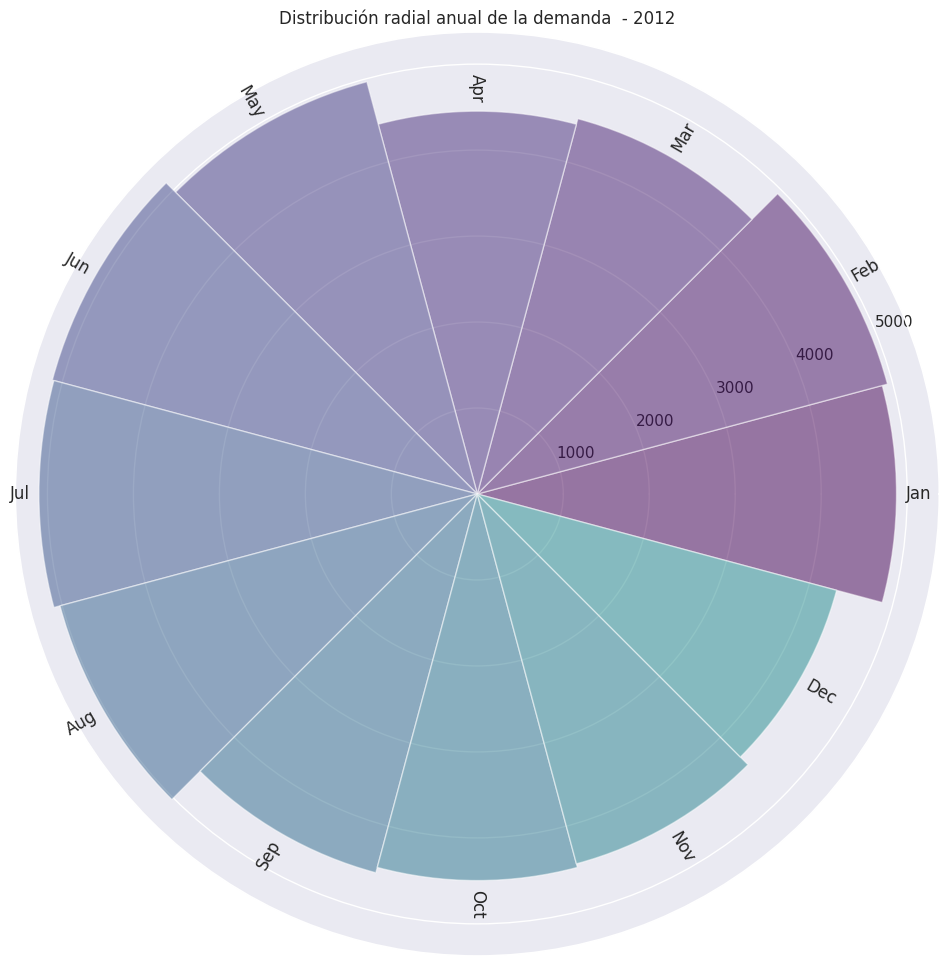

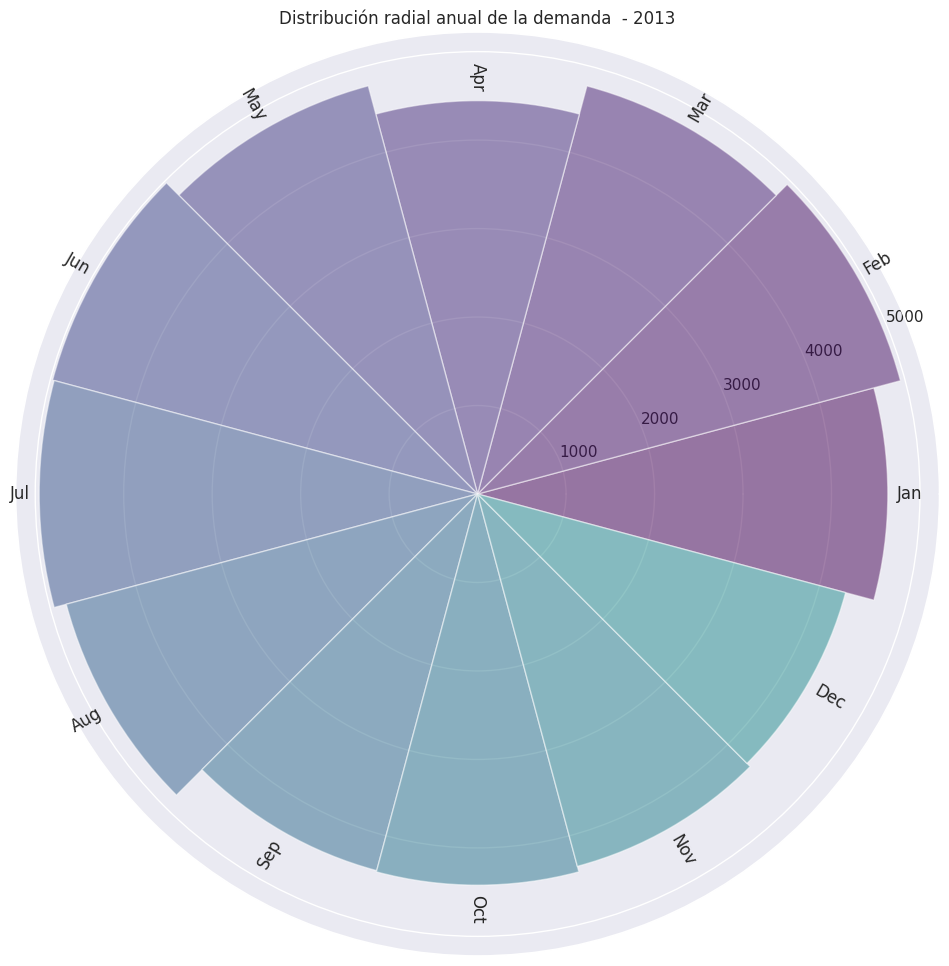

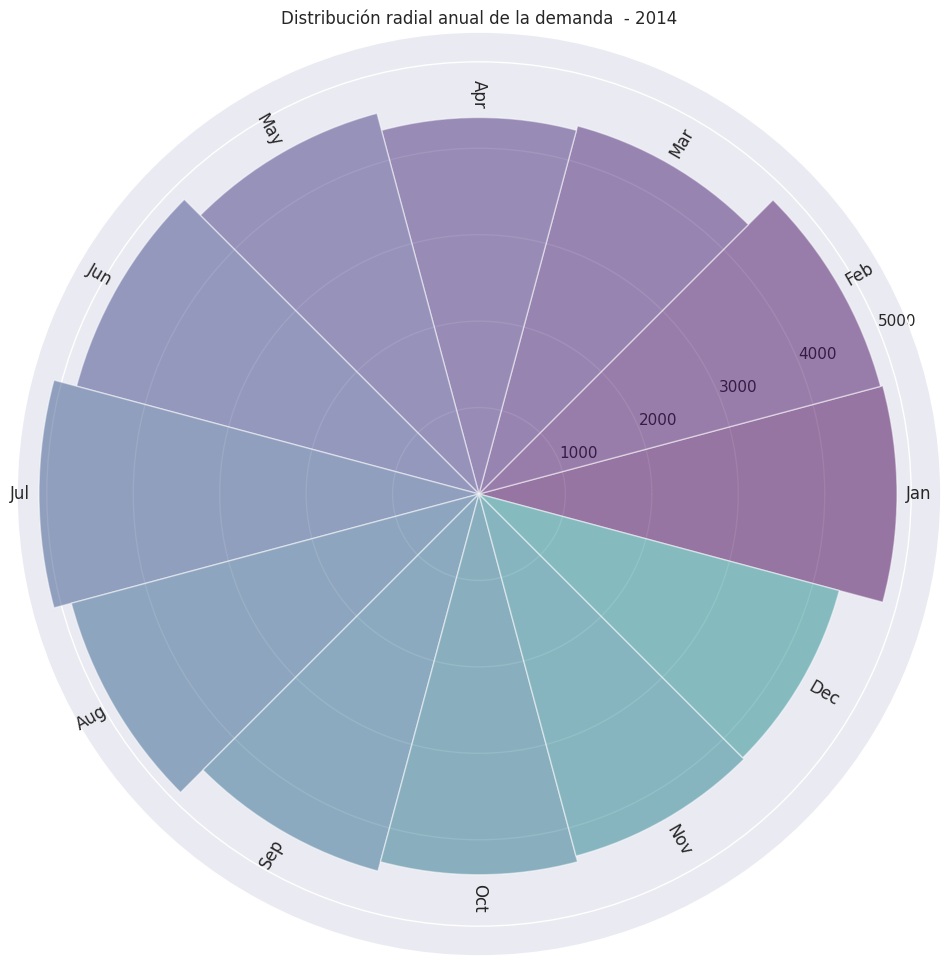

In [ ]:
#@title Gráfico radial
N = 12 #len(months) - 1

for i in years:
  plt.figure(figsize=(12,12))

  theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
  radii = df_monthly[df_monthly['y']==i]['Demand'] #10 * np.random.rand(N)
  width = 2 * np.pi / N #4 * np.random.rand(N)
  colors = plt.cm.viridis(theta / N)
  meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


  ax = plt.subplot(projection='polar')
  ax.bar(theta, radii, width=width, bottom=0.0, color=colors, edgecolor="white", alpha=0.5, label=meses)
  lowerLimit = 0.

  labelPadding = 4
  for angle, height, label in zip(theta, radii, meses):
      rotation = np.rad2deg(angle)
      alignment = ""
      if angle >= np.pi/2 and angle < 3*np.pi/2:
          alignment = "right"
          rotation = rotation + 180
      else:
          alignment = "left"
      ax.text(x=angle, y=lowerLimit + height + 100 + labelPadding,
              s=label, ha=alignment, va='center', rotation=rotation,
              rotation_mode="anchor")
      ax.set_thetagrids([], labels=[])

  plt.title(f'Distribución radial anual de la demanda  - {i}')
  plt.show()

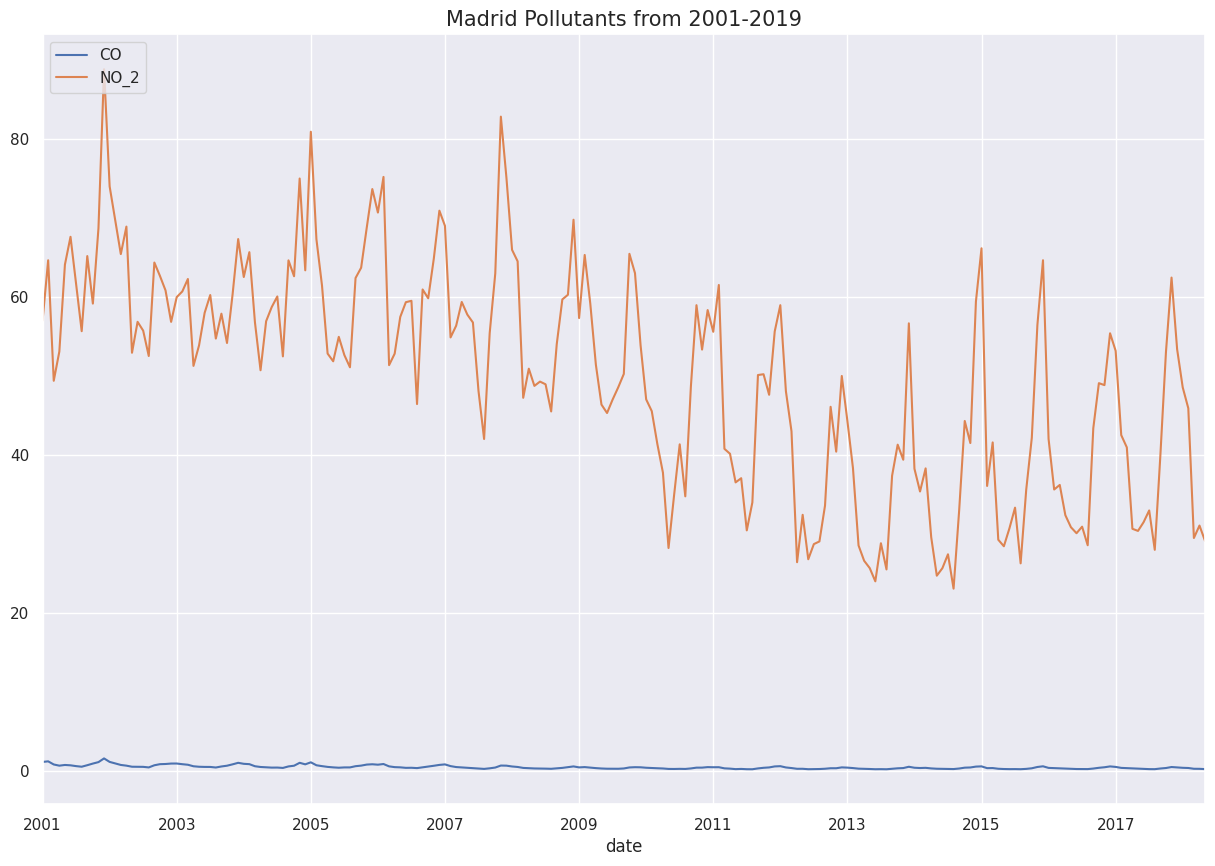

In [ ]:
#@title vemos los gases NO_2 y CO solamente, las escalas para analizar son diferentes!
'''
['CH4', 'MXY', 'NO', 'NOx', 'OXY', 'PM25', 'PXY']
Have been removed because they were missing large potions of data
'''
col_list = [ 'CO','NO_2']
monthly_df = df2.resample('M').mean()
daily_df = df2.resample('D').mean()

plt_monthly = monthly_df[col_list]
plt_monthly.plot(figsize=(15, 10))
plt.title('Madrid Pollutants from 2001-2019', fontsize=15)
plt.legend(loc='upper left')
plt.show()

### Características

Algunas características de la serie son:

- Se las puede ver como:

  - una muestra de tamaño 1 de un proceso estocástico.
  - T observaciones de T variables aleatorias, no independientes.

- La dependencia entre los valores de la serie no permite aplicar el análisis estocástico usual.
- Para definir algunos modelos estadísticos, una primera aproximación es suponer *estacionariedad* de al serie, es decir, que al serie se comporta siempre igual.

Tipos de estacionariedad:

- estricta: las distribuciones de probabilidad son iguales.
- débil: media, varianza y covarianza invariantes.

Se busca que tenga tendencia constante o sin tendencia.


## Análisis de Estacionalidad: modelos aditivos y multiplicativos

La descomposición de la estacionalidad es una herramienta de análisis que nos proporciona un marco sobre cómo pensar en los diferentes componentes de nuestra serie temporal. Podemos descomponer nuestra serie para comprender la influencia de cada componente y usar eso para guiar nuestra preparación de datos, selección de modelos y ajuste de modelos.

La descomposición estacional en `statsmodels` solo requiere que indiquemos si el modelo es aditivo o multiplicativo.

Esta es una descomposición ingenua, utilizada principalmente para la descripción de datos.

El modelo aditivo (muy buenos para tendencias) es $ Y(t) = T(t) + S(t) + e(t)$

El modelo multiplicativo (modelos explosivos) es $ Y(t) = T(t) \times S(t) \times e(t)$

Los resultados se obtienen estimando primero la tendencia aplicando un filtro de convolución a los datos. Luego, la tendencia se elimina de la serie y el promedio de esta serie sin tendencia para cada período es el componente estacional devuelto.




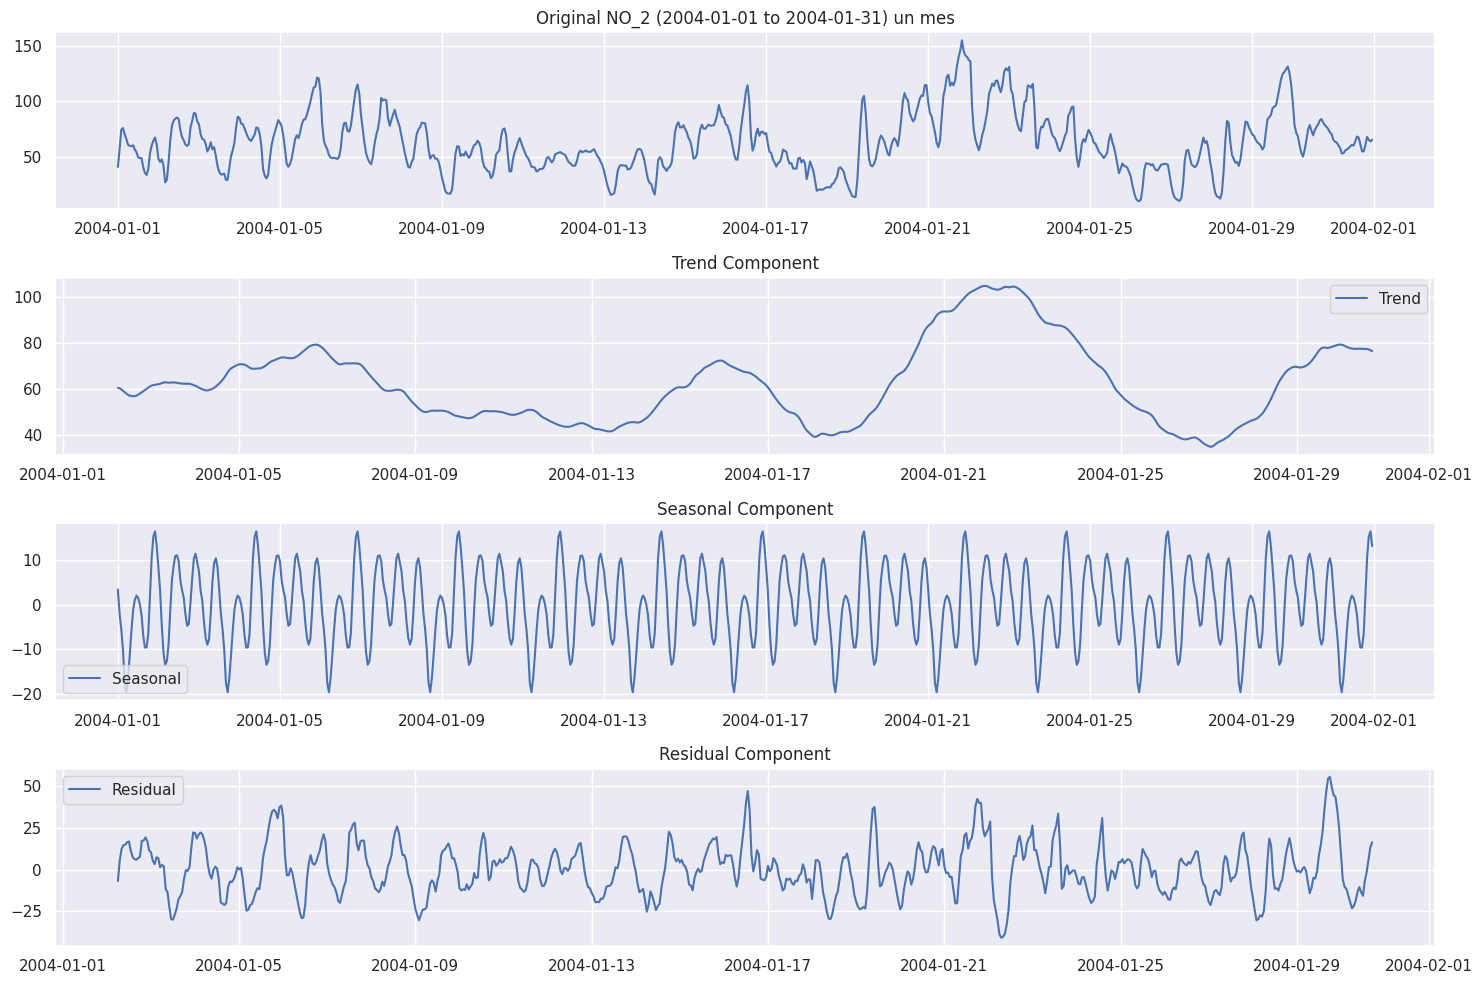

In [ ]:
#@title probando con estacionalidad aditiva para un mes en donde veo la estacionalidad

#un mes
#start_date2 = '2004-01-01'
#end_date2 = '2004-01-31'
#df_no2_subset2 = df_no2[start_date2:end_date2]

result = seasonal_decompose(df_no2_subset2, model='additive', period=60)

# Get the trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid


plt.figure(figsize=(15, 10))


#un mes

plt.subplot(4, 1, 1)
plt.plot(df_no2_subset2, label=gas)
plt.title(f'Original {gas} ({start_date2} to {end_date2}) un mes')
#plt.legend()


plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()


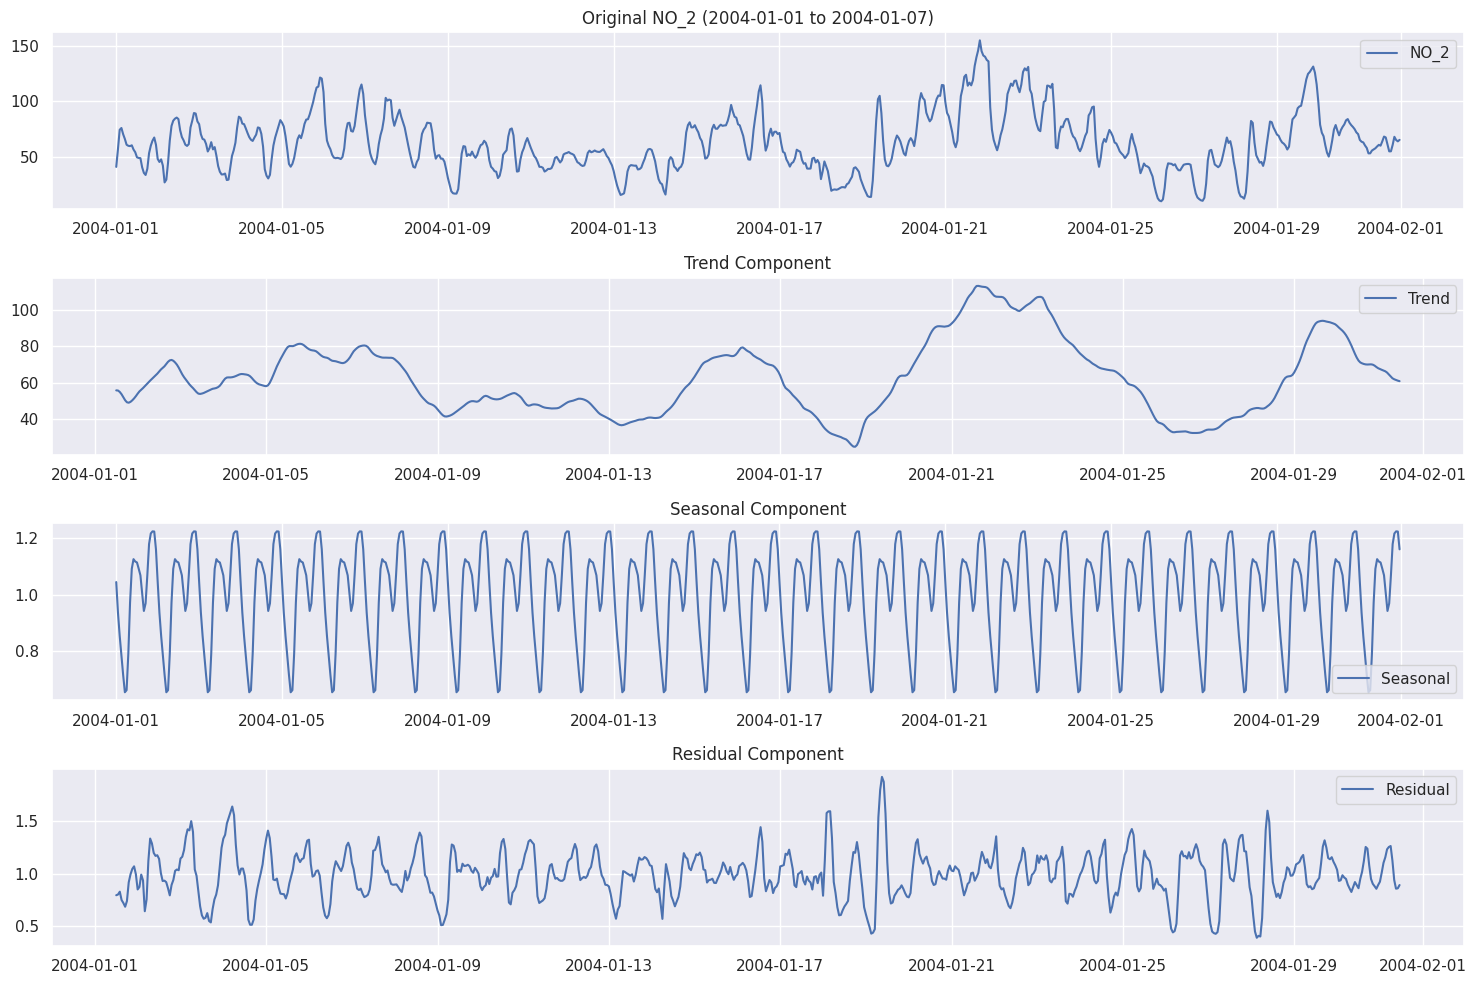

In [ ]:
#@title probando con "estacionalidad multiplicativa" para un mes en donde veo la estacionalidad

#start_date = '2001-01-01'
#end_date = '2004-12-31'
#df_no2_subset = df_no2[start_date:end_date]

# Perform seasonal decomposition
result = seasonal_decompose(df_no2_subset2, model='multiplicative', period=24)

# Get the trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the components
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(df_no2_subset2, label=gas)
plt.title(f'Original {gas} ({start_date} to {end_date})')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()


## Suavizado y Estadísticos

#### Suavizado


El suavizado es una técnica que podemos utilizar para reducir el ruido en nuestra serie temporal y realizar pronósticos. El pronóstico con técnicas de suavizado como el suavizado exponencial lineal (LES) y el suavizado exponencial simple (SES) puede funcionar para datos no estacionales donde la serie temporal es estacionaria localmente y tiene una tendencia leve.

Se utiliza el suavizado Triple Exponencial o de Holt-Winters y hace referencia a la ventana temporal que se trabaja y la serie geométrica (que es la versión discreta de la expoenencial que aparece). La predición se realiza del siguiente modo (a modo de ejemplo con el suavizado simple de Brow):

$$
F_{t+1} = \alpha\, x_t + (1-\alpha)\,F_t = F_t + \alpha\,(x_t - F_t)
$$

donde $x_t$ es el valor observado y $F_t$ última predicción.


Lo de Triple se debe a que utiliza 3 factores de suavizado que involucra la serie ($\alpha$), la tendencia ($\beta$) y la estacionalidad ($\gamma$).


Las técnicas de suavizado son fundamentales para las series temporales y se utilizan en varias aplicaciones, incluida la familia ARMA de modelos de pronóstico. Al suavizar, debemos prestar atención a la varianza y la forma de nuestras distribuciones de datos, ya que los modelos excesivamente suavizados pueden mostrar un alto sesgo, y el suavizado puede reducir demasiada varianza según nuestros parámetros.


### Estadísticos:

\begin{align}
\text{Estadístico} &\qquad \text{Expresión matemática} \\\hline
\text{media} &\qquad  \mu (t) = E(x_t) \\
\text{varianza} &\qquad \sigma ^2 (t) = E[ ( x_t - \mu(t) )^2 ] \\
\text{covarianza} &\qquad \gamma_h (t) = E[\, (x_t - \mu(t))\, (x_{t+h} - \mu(t+h))\, ] \\ \\
\text{autocorrelación de retardo $h$} &\qquad \rho_h = \frac{cov(x_t,x_{t+h})}{\sigma^2} \\
\end{align}


$E$ es el valor esperado. Estacionariedad implica $\mu, \sigma, \gamma_h \neq f(t)$. El ruido blanco es un ejemplo óptimo de estacionariedad ($x_t = x_{t-1} + a_t$).


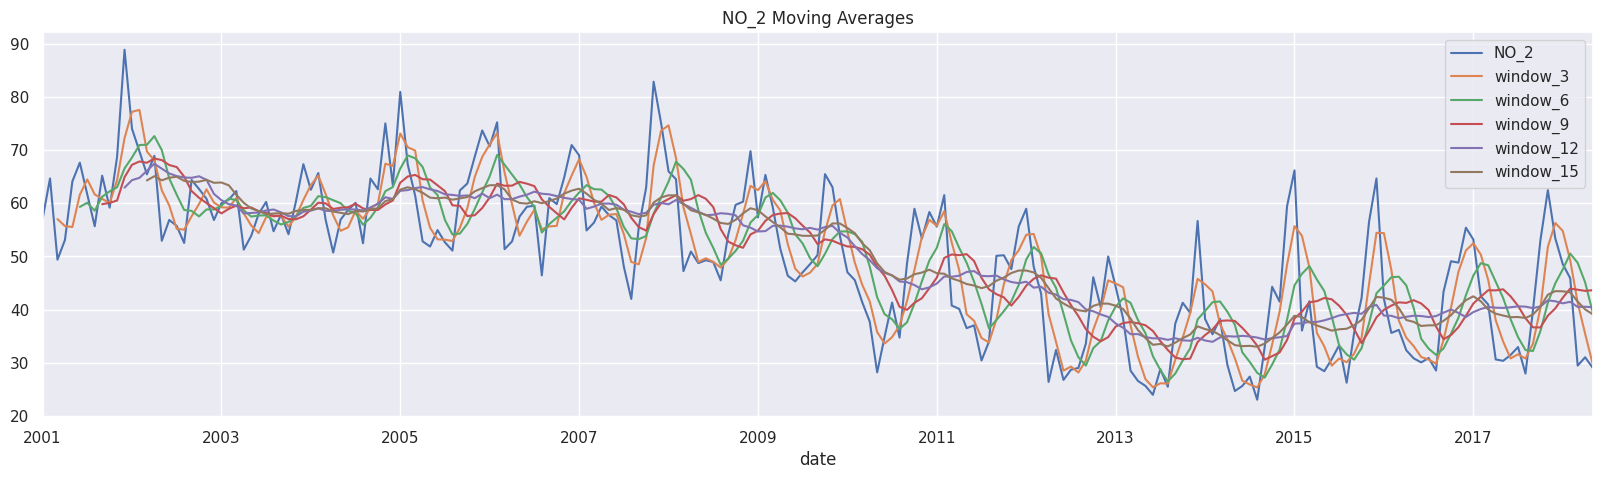

In [ ]:
#@title suavizado
SMA_df= pd.DataFrame(monthly_df.NO_2)
for n in range(1, 6):
    label = 'window_'+str(n*3)
    SMA_df[label] = SMA_df['NO_2'].rolling(window=n*3).mean()

SMA_df.plot(figsize=(20, 5), title='NO_2 Moving Averages')
plt.show()

In [ ]:
#@title Calculo del MSE para NO_2

error = {}
for col in SMA_df.columns[1:]:
    series = SMA_df[['NO_2', col]]
    series = series.dropna(axis=0)
    error[col] = mean_squared_error(series['NO_2'], series[col])
    print(f'Moving Average {col} MSE: ', round(error[col], 2))

metadata = {'mean':[], 'variance':[], 'skew':[], 'kurtosis':[]}
for col in SMA_df:
    metadata['mean'].append(SMA_df[col].mean())
    metadata['variance'].append(SMA_df[col].var())
    metadata['skew'].append(SMA_df[col].skew())
    metadata['kurtosis'].append(SMA_df[col].kurt())

Moving Average window_3 MSE:  35.02
Moving Average window_6 MSE:  86.57
Moving Average window_9 MSE:  106.49
Moving Average window_12 MSE:  89.01
Moving Average window_15 MSE:  73.88


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

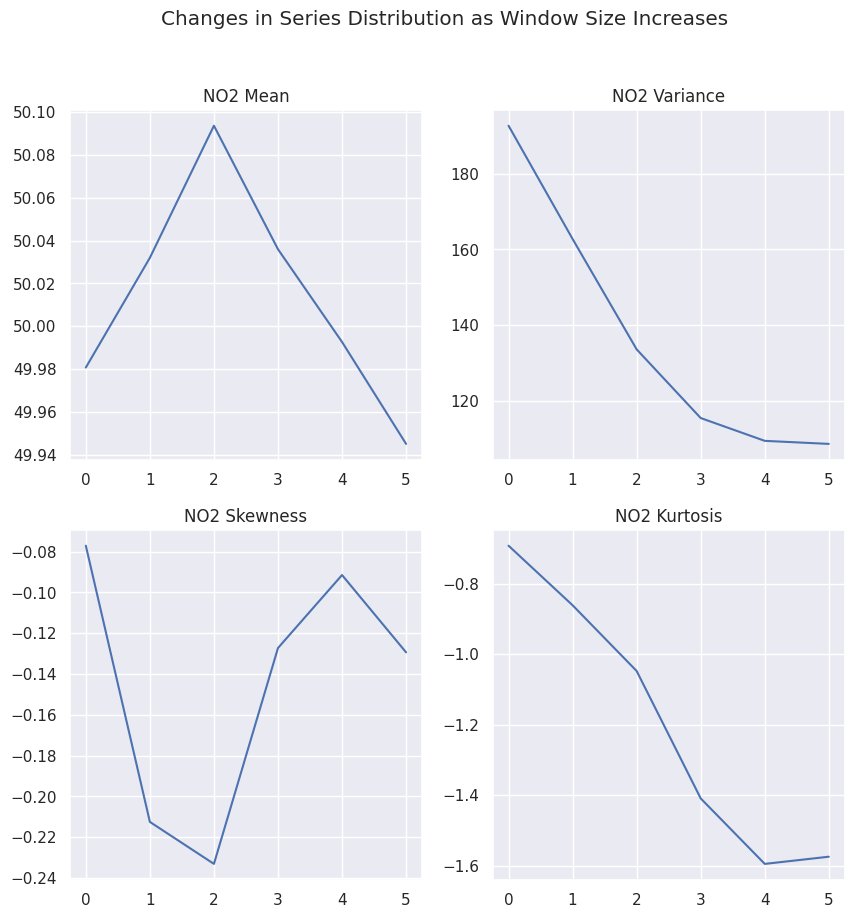

In [ ]:
#@title Análisis grafico de los cambios de la distribución de la Serie de Tiempo para diferentes ventanas para NO_2

plt.figure(figsize=(10,10))
plt.suptitle('Changes in Series Distribution as Window Size Increases')
plt.subplot(221)
plt.title('NO2 Mean')
plt.plot(metadata['mean'])
plt.subplot(222)
plt.title('NO2 Variance')
plt.plot(metadata['variance'])
plt.subplot(223)
plt.title('NO2 Skewness')
plt.plot(metadata['skew'])
plt.subplot(224)
plt.title('NO2 Kurtosis')
plt.plot(metadata['kurtosis'])
plt.show()

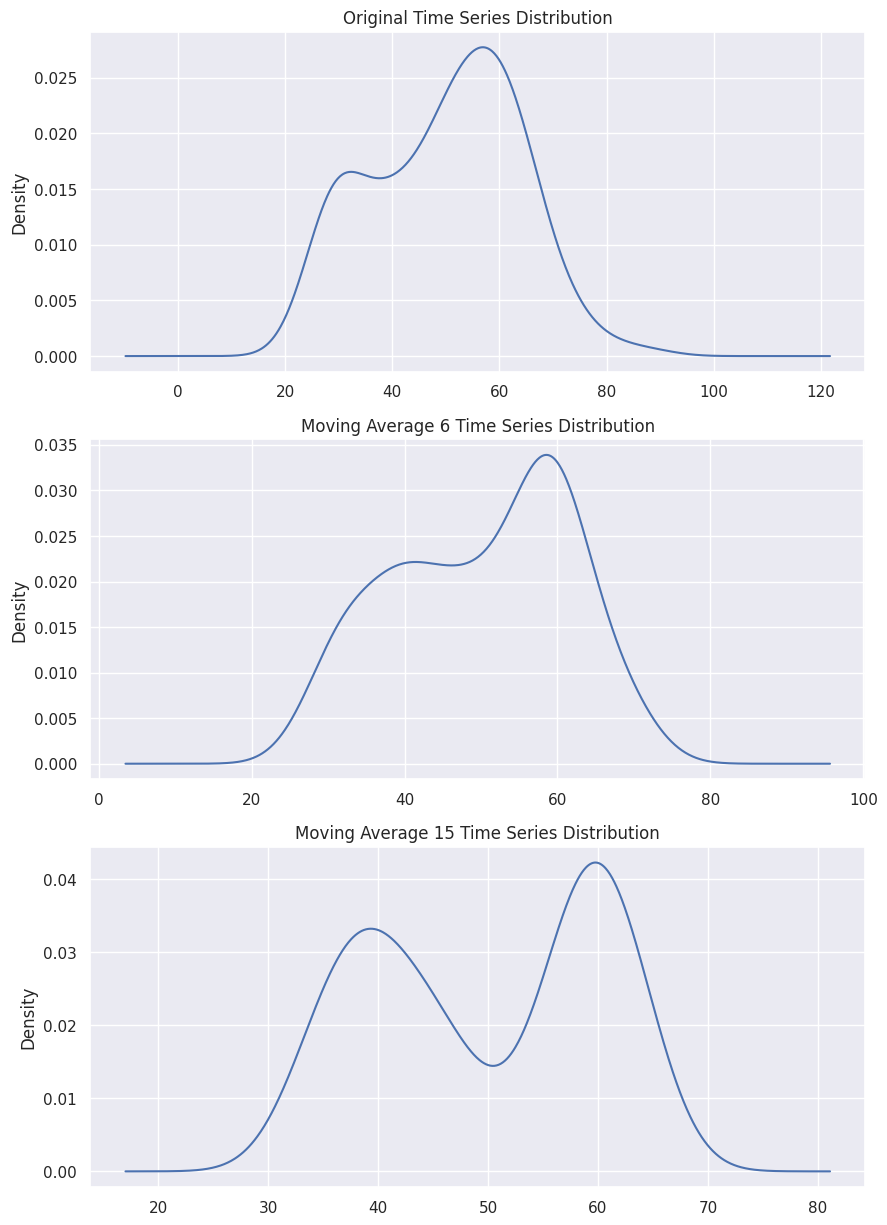

In [ ]:
#@title Distribuciones de densidad

plt.figure(figsize=(10, 15))
plt.subplot(311)
plt.title('Original Time Series Distribution')
SMA_df.NO_2.plot(kind='kde')
plt.subplot(312)
plt.title('Moving Average 6 Time Series Distribution')
SMA_df['window_6'].plot(kind='kde')
plt.subplot(313)
plt.title('Moving Average 15 Time Series Distribution')
SMA_df['window_15'].plot(kind='kde')
plt.show()

## Series no estacionarias

Test estadístico ADF (Augmented Dickey Fuller), que testea si existe raíz unitaria, es decir, estacionariedad en tendencia:

- Hipótesis Nula ($H_0$): la serie tiene una raíz unitaria, no es estacionaria.
- Hipótesis Alternativa ($H_A$): la serie no tiene raíz unitaria, es estacionaria.

Ejemplo de raíz unitaria es la caminata aleatoria:
$$
x_t - x_{t-1} = a_t \implies (1-L)\, x_t = a_t
$$
Donde se piensa a $(1-L)$ como un operador de retardo.

Y se busca que al realizar el test el *p-value* sea un valor muy pequeño, ya que esto indica la estacionariedad de la serie.

El test KPSS (Kwiatkowski-Phillips-Schmidt-Shin) comprueba estacionariedad en torno a una media o tendencia lineal. Ahora $H_0$ es que la serie es estacionaria, por lo tanto *p-value* muy pequeños rechanzan $H_0$ y sugieren que es necesario diferenciar (ver *diferenciar*).

La biblioteca *statsmodels* implementa ambos test:

```python
from statsmodels.tsa.stattools import adfuller, kpss
# ADF: adfuller()
# KPSS: kpss()
```

Se utilizan las funciones de autocorrelación y autocorrelación parcial (ACF y PACF respectivamente) en los casos donde $\rho_h \neq f(t)$.



#### Análisis de Autocorrelaciones

Los gráficos de ACF y PACF proporcionan información útil sobre los posibles valores de $p$ y $q$. ACF ayuda a identificar el valor de $q$ (retardos en la parte de MA) y PACF en identificar $p$ (retardos en la parte AR).

<!---
Ejemplos de ACF y PACF:

![ejemplos acf y pacf](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.ZGvIepkyierv0_Ul7T9qngHaE8%26pid%3DApi&f=1&ipt=ba4240f65af9f582e96508005e4dc4747c7433a0516fad62d7e18b9563db2033&ipo=images)

--->




In [ ]:
#@title Gráficos conjuntos

def tsplot(y, lags=None, figsize=(15, 10), style='bmh', title = 'Time Series Analysis Plots' ):
    '''Esta función muestra el gráfico de la serie y de las funciones ACF y PACF.'''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_ylabel(r'$y_t$')
        ts_ax.set_xlabel(r'$t$')
        ts_ax.set_title(title)
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### Modelos AR (autorregresivos)

Son modelos de series temporales, asumen estacionariedad de la seria e intentan *capturar* la tendencia con los retardos y con las innovaciones anteriores.

Ejemplo modelo AR(1):
$$
x_t = a_0 + a_1 x_{t-1} + \varepsilon_t
$$
(con $a_1=1$ se tiene una caminata aleatoria).
Los modelos AR(1) tienen como condición que $|a_1|\lt 1$ para que la serie sea **estacionaria**.

Un modelo AR(p) sería:
$$
x_t = a_0 + a_1x_{t-1} + a_2x_{t-2} + \ldots + a_px_{t-p} + \varepsilon_t.
$$

Pensada con el *operador retardo* se tiene que: $Lx_t = x_{t-1}$, entonces AR(1): $(1-a_1 L)x_t = \varepsilon_t$. La ecuación $(1-a_1 z) = 0$; posee solución si $|z|>1$ (puede ser compleja; $z=\frac{1}{a_1}$). En general, en un AR(p) se tiene:
$$
(1-a_1L-a_2L^2 - a_3L^3 \ldots - a_pL^p) x_t = \varepsilon_t,
$$
con solución estacionaria si $|z_i|>1$ en la ecuación:
$$
1-a_1z - a_2z^2 - a_3z^3 \ldots - a_pz^p = 0.
$$
Y se utiliza:
- ACF que no da mayor información
- PACF de orden $p+1$ en adelante se anulan (en la teoría).



#### Ejemplo de Modelo MA(1)
Modelo MA(1) que responde a la fórmula:
$$ x_t = a_t - 0.7 a_{t-1}$$
Se genera una serie de tiempo con 300 valores.



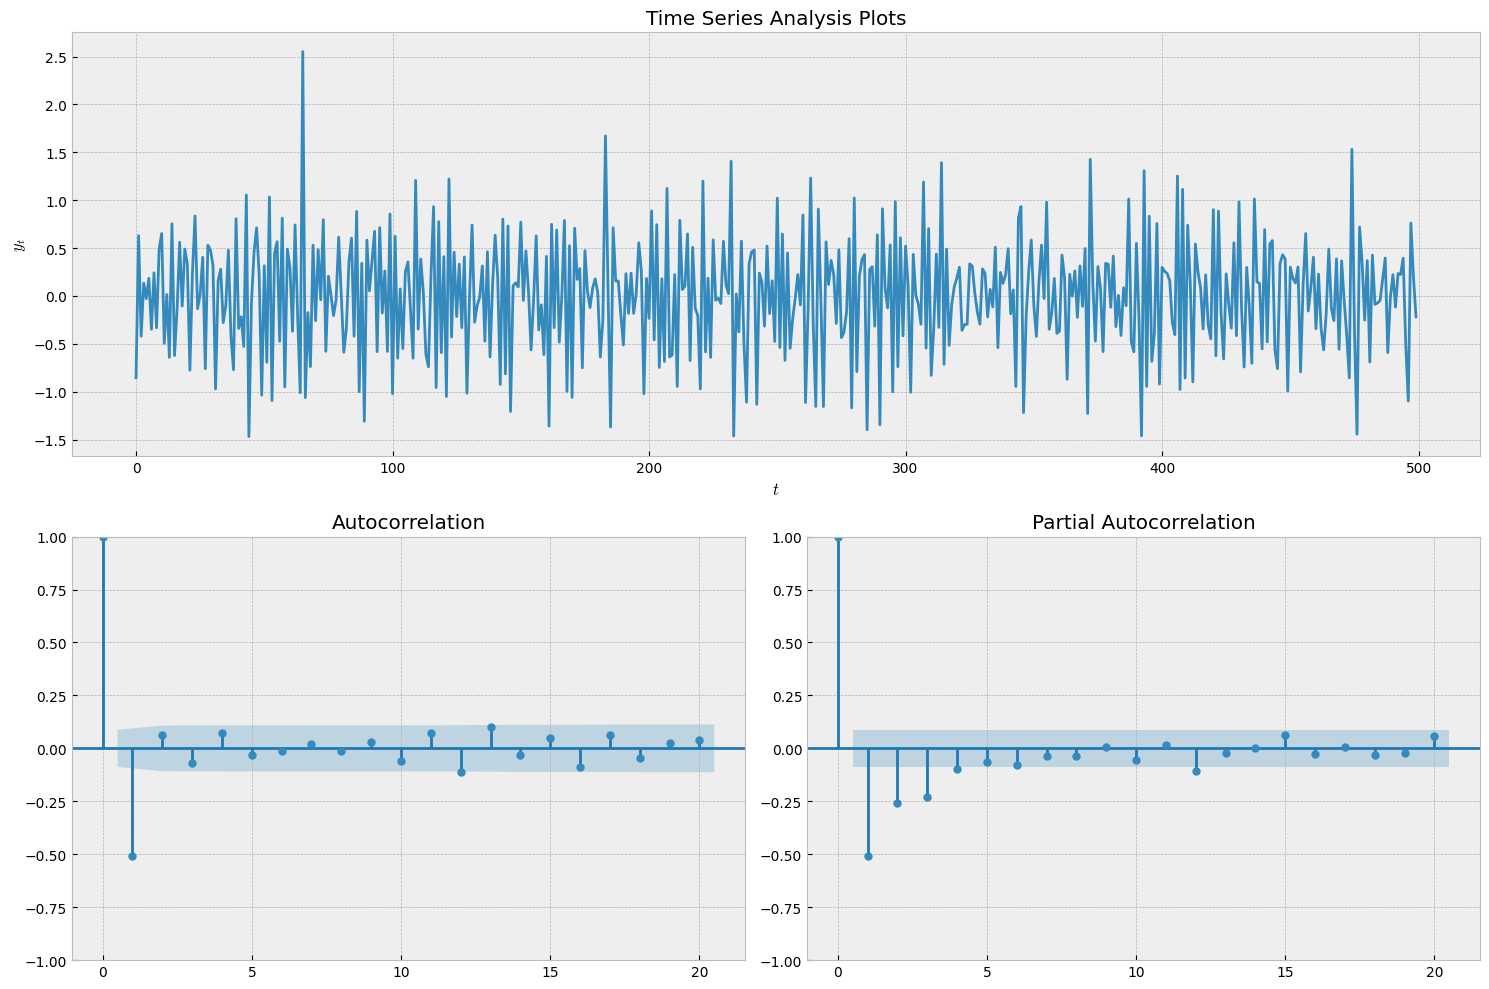

In [ ]:
# Importar la función para generar la serie.
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(1)

# Inicializar los coeficientes del modelo.
ar_coefs = [1]
ma_coefs = [1, -0.7]

burn_in = 500
# Generar la serie.
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=500, scale=0.5, burnin= burn_in)

#plt.plot(y)
#plt.ylabel(r'$y_t$')
#plt.xlabel(r'$t$')
#plt.show()
tsplot(y, lags = 20)

### Modelos MA (moving average)

En lugar de mirar los retardos en $x_t$, se los analiza en $\varepsilon_t$ con coeficientes ${m_1, m_2, \ldots m_q}$. Ejemplo  MA(q):
$$
x_t = \varepsilon_t + m_1\varepsilon_{t-1} + m_2\varepsilon_{t-2} + \ldots + m_q\varepsilon_{t-q}
$$
Tener en cuenta siempre son estacionarios ya que los $\varepsilon$'s son ruido blanco.

Y se utiliza:
- PACF que no brindan mayor información)
- ACF: $\rho_h = 0$ para $h>q$

para verificar la estacionariedad. Se dice que son los modelos de memoria corta porque el modelo "recuerda" hasta orden $q$.

#### Diferenciar

Si la serie **no** es estacionaria, se la diferencia ($\Delta x_t = x_t - x_{t-1}$) y se trabaja con ésta nueva variable. Se puede diferenciar la cantidad de veces necesaria hasta conseguir estacionariedad (ver ARFIMA).

#### Ejemplo de Modelo AR(1)
Modelo AR(1) que responde a la siguiente fórmula:
$$x_t = -0.7x_{t-1} + \epsilon_t. $$
Y su gráfico.


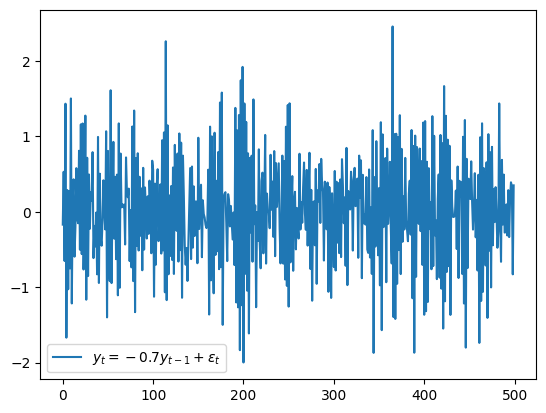

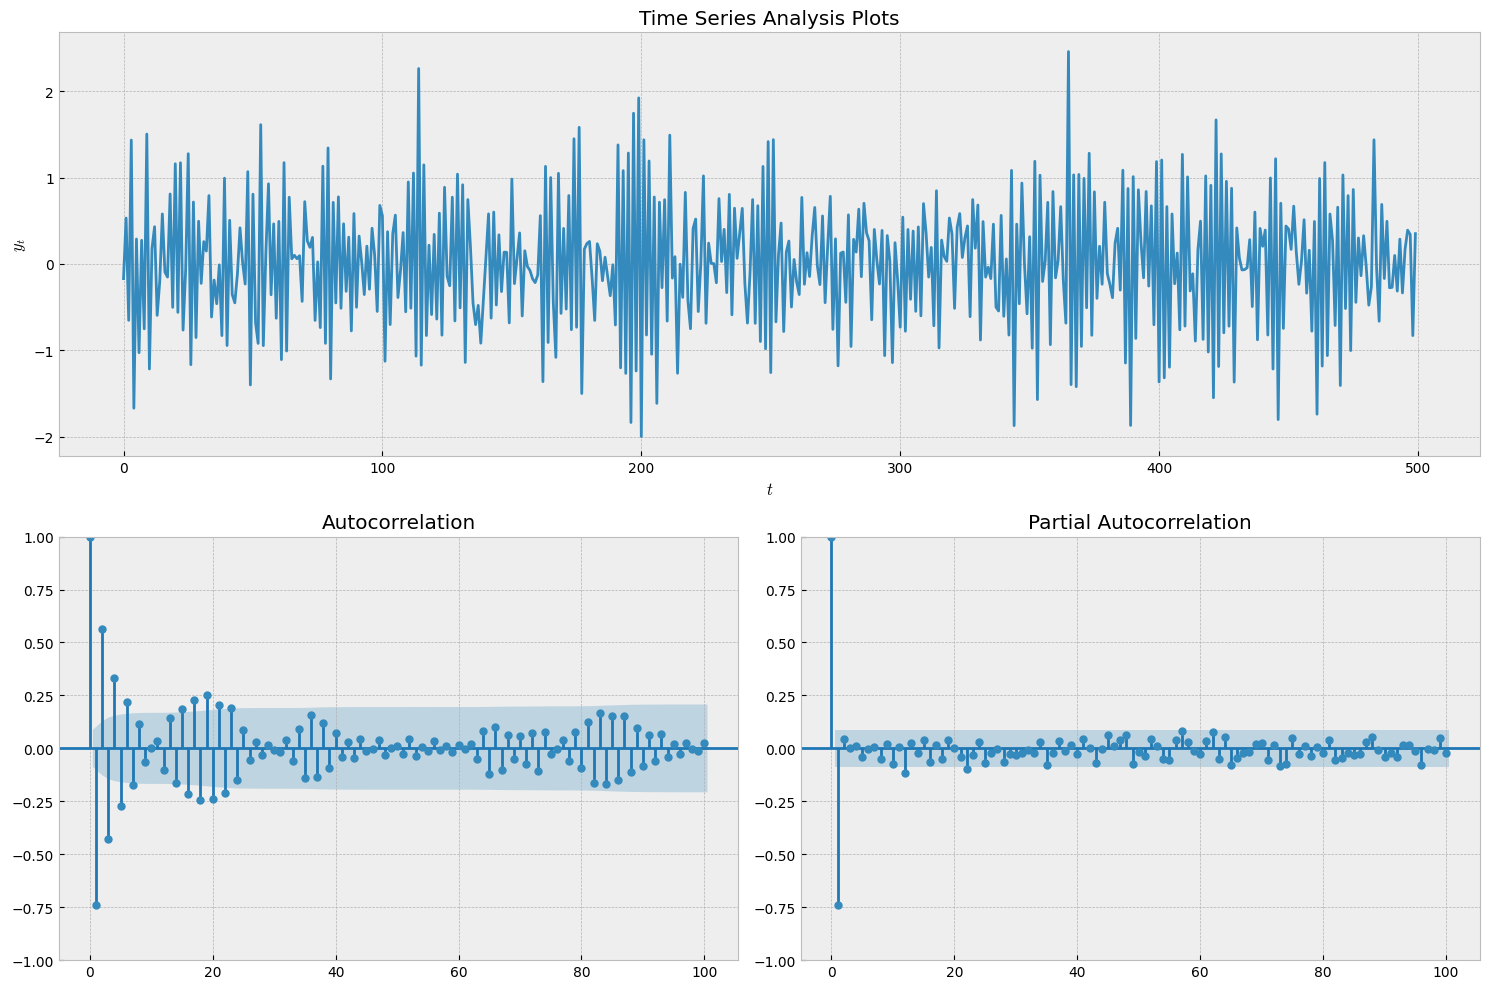

In [ ]:
####
np.random.seed(1)

# Inicializar los coeficientes del modelo.
ar_coefs = [1, 0.7]
ma_coefs = [1]

# Generar la serie.
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=500, scale=0.5, burnin = 200)
plt.plot(y, label = r'$y_t = -0.7 y_{t-1} + \epsilon_t$')
plt.legend()
tsplot(y, lags = 100) #100 para ver la oscilación

### Modelos ARMA, ARIMA Y ARFIMA

#### ARMA(p,q)

Donde $p$ es hasta que retardo se considera (memoria larga) y $p$ es hasta que retardo del ruido se considera (memoria corta). ¡Tener cuidado al cargar los coeficientes, principalmente en AR! Para usar el modelo se utiliza el de valor más bajo.


#### ARIMA(p,d,q)

Es un modelo ARMA con I de Integrada. Entonces:

$$
\text{con variable: }\Delta x_t \text{ es ARMA(p,q)} \implies \text{ARIMA(p,1,q)},
$$
y el modelo utilizado sólo se encarga de diferenciar.

#### ARFIMA(p,d,q)

Ahora FI significa Fraccionario Integrado. Sus características son.
- series de tiempo que rechazan ADF pero deja dudas.
- hay una alta persistencia en las correlaciones.
- puede ocurrir que al diferenciarla, o aplicarles alguna transformación, se pierden propiedades.
- ACF muestra alta persistencia

Un posible inconveniente es que una diferenciación de orden 1 sea más que suficiente para lograr la estacionariedad. Los modelos ARFIMA(p,d,q) consideran la posibilidad de diferenciar un orden d fraccionario.

Si $L$ denota la operación de retardo, y $d$ es un número fraccionario, entonces la diferencia de orden $d$ de la serie $x_t$ se define como:

$$(1-L)^d x_t= d x_{t-1} + \frac{d(d-1)}{2!} x_{t-2} -  \frac{d(d-1)(d-2)}{3!} x_{t-3} + \frac{d(d-1)(d-2)(d-3)}{4!} x_{t-4} - \dots $$

- Si $d$ es un entero, la suma es finita y la definición coincide con la diferenciación usual de orden $d$.
- Si $d$ es una fracción, la suma tiene infinitos términos.
- Si una serie $x_t$ verifica que

$$(1-L)^d x_t = \epsilon_t,$$

con $\epsilon_t$ un ruido blanco o $\epsilon_t$ un modelo ARIMA(p,0,q),
entonces $x_t$ responde a un modelo ARFIMA(0,d,0) o ARFIMA(p,d,q), respectivamente.

Si $|d| < 0.5$, la serie $x_t$ resulta estacionaria.

#### Ejemplo de Modelo ARMA(1,2) o ARIMA(1,0,2)
Modelo:
$$x_t = -0.2x_{t-1} + 0.3 a_{t-1} + 0.4 a_{t-2} + a_t.$$
Y su gráfico.

Modelo ARIMA(1,0,2) creado y luego se ajusta a este modelo.

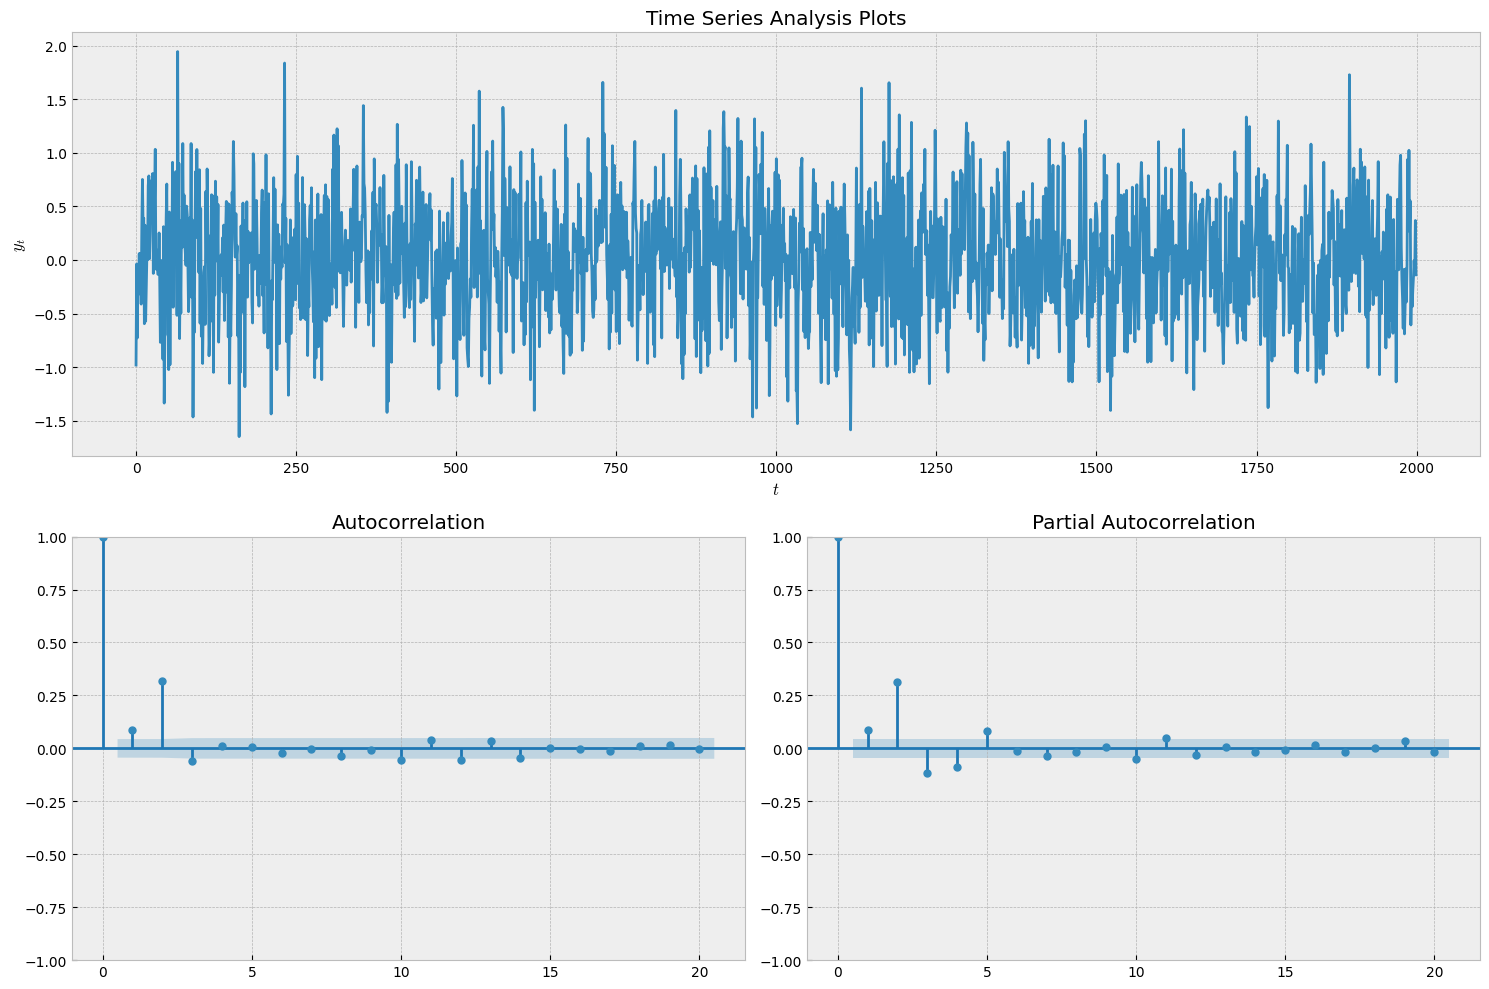

In [ ]:
## Crear un ARMA(1,2)
np.random.seed(1)

# Inicializar los coeficientes del modelo.
ar_coefs = [1, 0.2]
ma_coefs = [1, 0.3, 0.4 ]

# Generar la serie.
y = arma_generate_sample(ar_coefs, ma_coefs, nsample = 2000, scale=0.5, burnin = 500)

tsplot(y, lags = 20)

In [ ]:
#@title Ajuste del modelo a un ARIMA(1,0,2).

# Importamos el modelo ARIMA
from statsmodels.tsa.arima.model import ARIMA
# Instanciamos el modelo
model = ARIMA(y, order= (1,0,2))

# Ajustamos el modelo
results = model.fit()


In [ ]:
#@title Resumen estadístico
## Imprimimos el resumen estadístico
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Serie   No. Observations:                 2000
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1467.611
Date:                Wed, 06 Dec 2023   AIC                           2945.221
Time:                        02:32:55   BIC                           2973.226
Sample:                             0   HQIC                          2955.504
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0114      0.016      0.721      0.471      -0.020       0.042
ar.L1         -0.2226      0.059     -3.776      0.000      -0.338      -0.107
ma.L1          0.3168      0.054      5.898      0.0

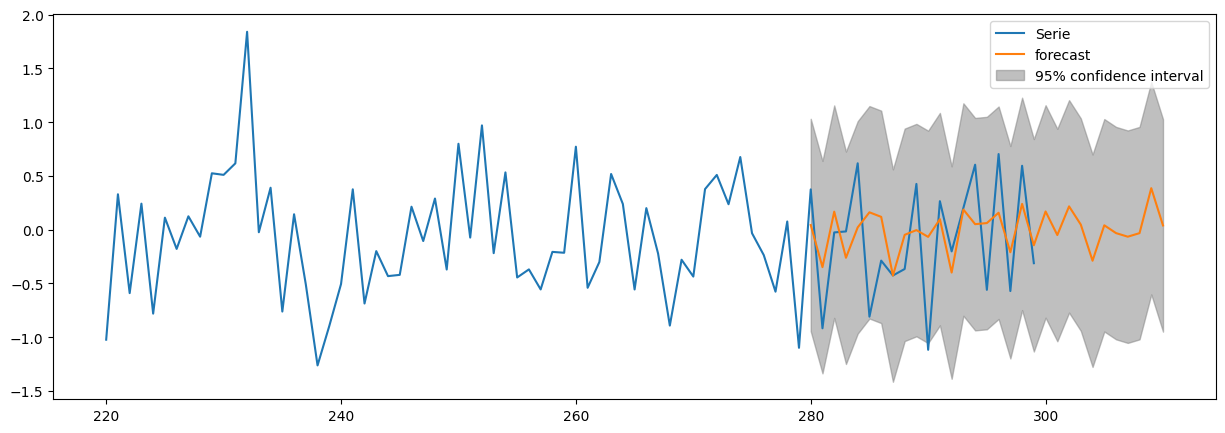

In [ ]:
#@title Análsisi de predicción del modelo dentro y fuera de la muestra

from statsmodels.graphics.tsaplots import plot_predict


fig, ax = plt.subplots(figsize = (15,5))
y.iloc[220:300].plot(ax=ax)

plot_predict(results, 280, 310,  ax = ax)
plt.show()


In [ ]:
#@title Resultados

spy = pd.read_csv('SPY.csv', index_col = 'Date', parse_dates = True)
spy_lrets = np.log(spy/spy.shift(1)).dropna()
model_fit = ARIMA(spy_lrets['Adj Close'], order = (1,0,1)).fit()
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5140
Model:                 ARIMA(1, 0, 1)   Log Likelihood               15231.171
Date:                Wed, 06 Dec 2023   AIC                         -30454.341
Time:                        02:33:03   BIC                         -30428.162
Sample:                             0   HQIC                        -30445.178
                               - 5140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.359      0.174   -9.98e-05       0.001
ar.L1          0.1973      0.052      3.761      0.000       0.094       0.300
ma.L1         -0.2959      0.051     -5.839      0.0

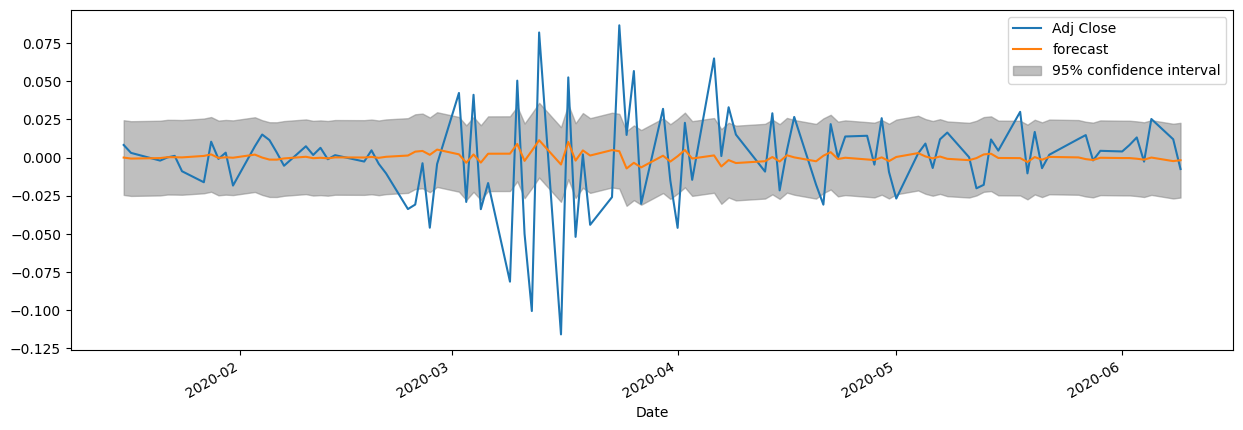

In [ ]:
#@title Gráfico con predicción "corta"

fig, ax = plt.subplots(figsize = (15,5))
spy_lrets['Adj Close'].iloc[-100:].plot(ax=ax)
#model_fit.fittedvalues.iloc[-100:].plot( ax=ax, label = 'Fitted values')
plt.legend()
plot_predict(model_fit,start = spy_lrets.index[-100], end = spy_lrets.index[-1], ax = ax)
plt.show()

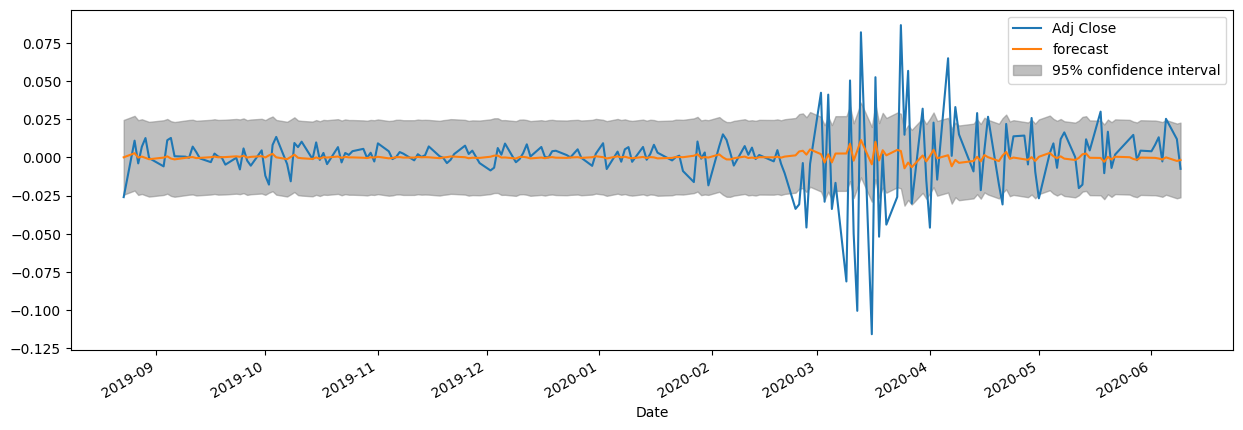

In [ ]:
#@title Gráfico con predicción "larga"

fig, ax = plt.subplots(figsize = (15,5))
spy_lrets.dropna()['Adj Close'].iloc[-200:].plot(ax=ax)
x = model_fit.fittedvalues
#x.iloc[-200:].plot(ax=ax, label = 'Fitted values')
plt.legend()
plot_predict(model_fit,start = spy_lrets.index[-200], end = spy_lrets.index[-1], ax = ax)
plt.show()

#### Ejemplo modelo ARFIMA(p,d,q)

El módulo arfima posee la función arfima($[ar],d,[ma]$, size) que genera una serie ARFIMA(p,d,q).
$[ar]$ y $[ma]$: contienen los parámetros distintos de 1 de las componentes AR y MA respectivamente.

In [ ]:
model_arfima = arfima([0], 0.6, [0], 1000)

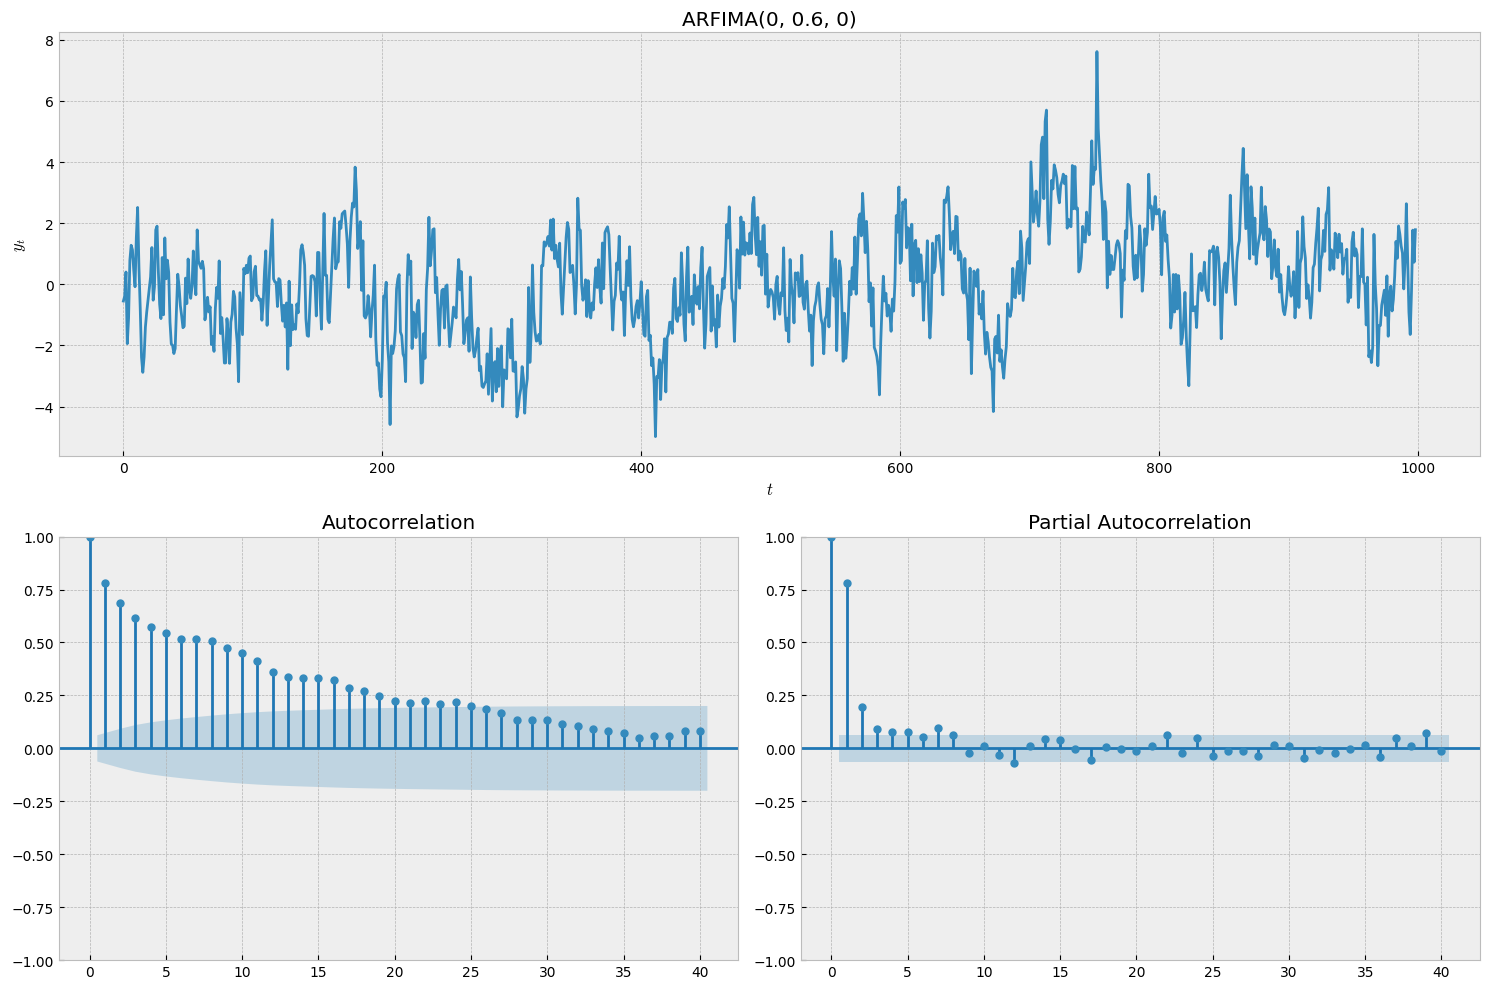

In [ ]:
tsplot(model_arfima, lags = 40, title = 'ARFIMA(0, 0.6, 0)')

En la gráfica anterior puede observarse la persistencia de la correlación entre los retardos de la serie. No decrecen exponencialmente como ocurriría en un modelo ARMA.

Aplicamos los test ADF y KPSS para analizar la estacionariedad de la serie.

In [ ]:
adfuller(model_arfima)[0:2]

(-5.038337489277755, 1.8625584643653296e-05)

In [ ]:
kpss(model_arfima)[0:2]

(1.2161957880666132, 0.01)

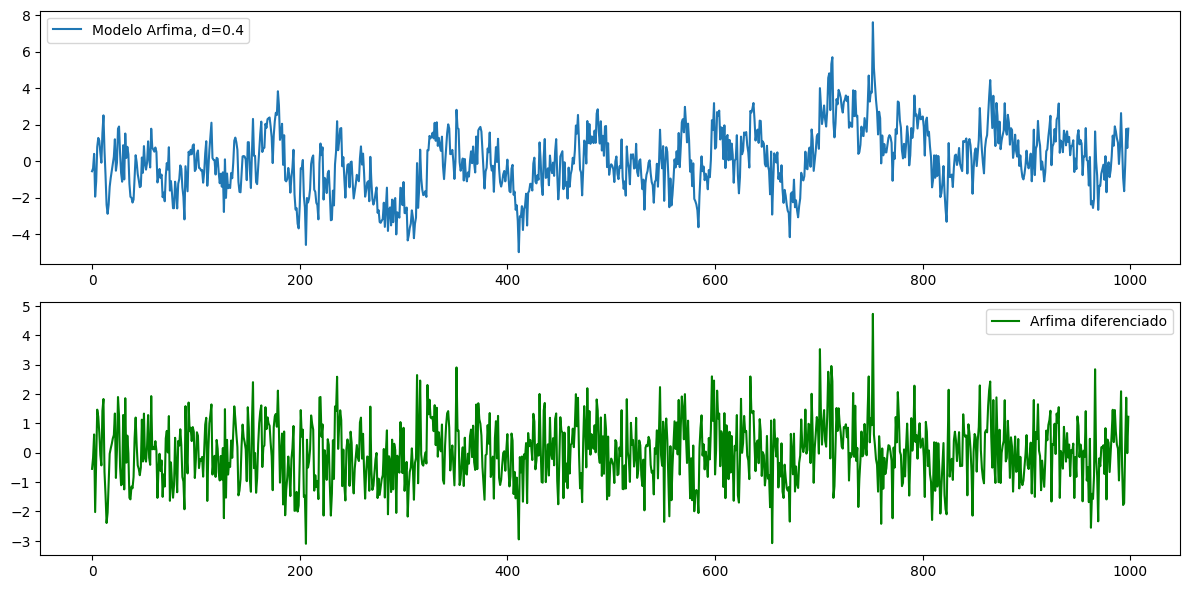

In [ ]:
#@title Gráficos

arfima_diff = __frac_diff(model_arfima, 0.4)
fig = plt.figure(figsize = (12,6))
layout = (2,1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = plt.subplot2grid(layout, (1, 0))
ax1.plot(model_arfima,  label = 'Modelo Arfima, d=0.4')
ax1.legend(loc = 'upper left')
ax2.plot(arfima_diff, label = 'Arfima diferenciado', color = 'green')
ax2.legend()
plt.tight_layout()
plt.show()

#### Ejemplo en Serie financiera

Consideraremos las diferenciaciones de orden d de la serie de datos de AAPL, y elegimos como mejor orden de diferenciación al primero que rechaza el test ADF con un p-valor menor a $0.005$.
Aplicamos la diferenciación de orden d con la función `__frac_diff(x, d)` del módulo arfima.

In [ ]:
aapl_diff = __frac_diff(data['Adj Close'].dropna().values, 0.6)
for i in range(10):
    aapl_diff = __frac_diff(data['Adj Close'].dropna().values, i/10)
    pvalue = adfuller(aapl_diff)
    print('d=',i/10, adfuller(aapl_diff)[1])
    if pvalue[1] < 0.005:
        d = i/10
        break


d= 0.0 0.9933527012638801
d= 0.1 0.9621243055014049
d= 0.2 0.8522822716385364
d= 0.3 0.4803238966131036
d= 0.4 0.056157114480474266
d= 0.5 8.0119649907321e-05


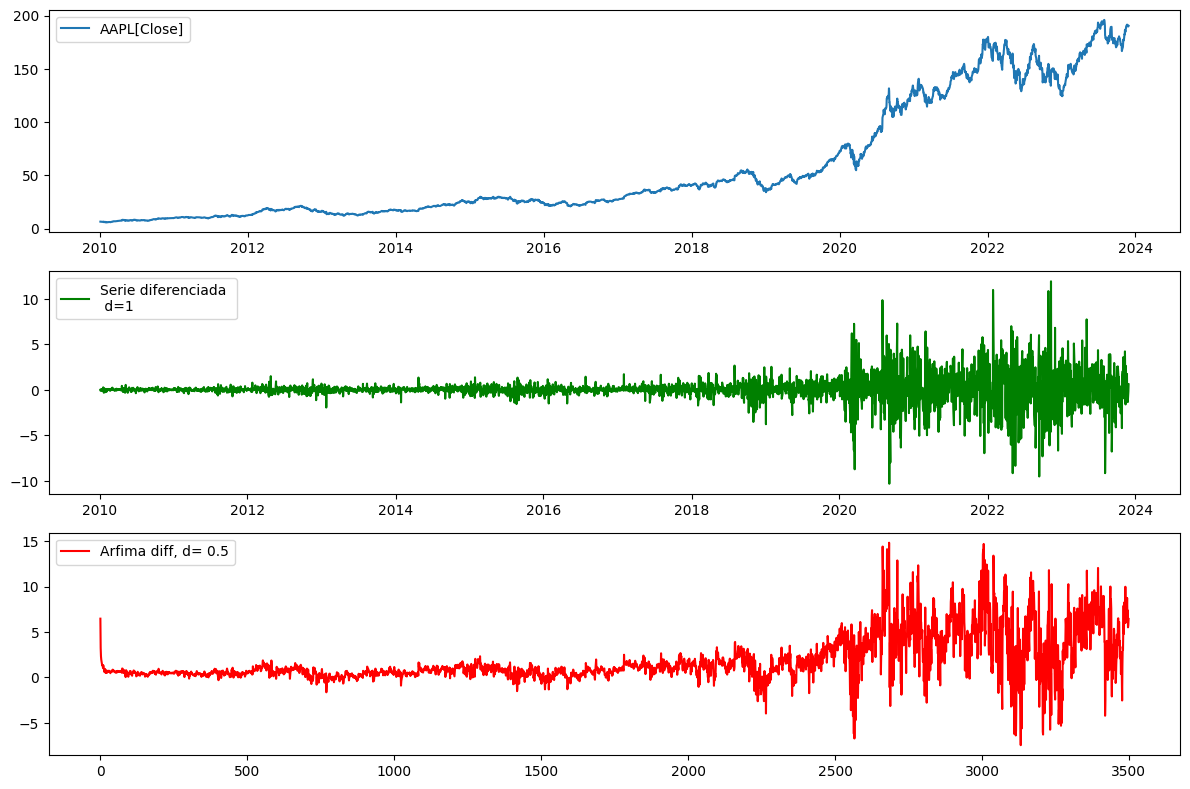

In [ ]:
#@title Gráficos sin diferenciar y con diferenciación entera (d=1) y fraccionaria (d=0.5)

fig = plt.figure(figsize = (12,8))
layout = (3,1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = plt.subplot2grid(layout, (1, 0))
ax3 = plt.subplot2grid(layout, (2, 0))
ax1.plot(data['Adj Close'],  label = 'AAPL[Close]')
ax1.legend()
ax2.plot(data['Adj Close'].diff(), label = 'Serie diferenciada \n d=1 ', color = 'green')
ax2.legend()
ax3.plot(aapl_diff,  label = f'Arfima diff, d= {d}', color = 'red'  )

ax3.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

### Modelo SARIMAX

Los modelos SARIMAX son modelos ARIMA con características estacionales (Seasonal) y variables exógenas (X, datos externos en la predicción).

Ejemplos de modelos:

- [SARIMA](https://github.com/ritvikmath/Time-Series-Analysis/blob/master/SARIMA%20Model.ipynb),
- [SARIMAX 1](https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python#Modelo-ARIMA-SARIMAX) y
- [SARIMAX 2](https://skforecast.org/0.13.0/user_guides/forecasting-sarimax-arima.html#)